In [2]:
import os
import pandas as pd
import numpy as np

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop, SGD
from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [3]:
X_topic = []
Y_topic = []

X_path = 'topic_vectors.txt'
Y_path = 'topic_names.txt'

if(os.path.isfile(X_path) and os.path.isfile(Y_path)):
    print('load from .txt file')
    X_topic = np.loadtxt(X_path)
    with open(Y_path, 'r') as f:
        for line in f.readlines():
            Y_topic.append(line.replace('\n',''))
    Y_topic = np.array(Y_topic)

load from .txt file


In [4]:
bolezni = pd.read_csv('../parse-html/bolezni.csv')
X_categ = []
for i in bolezni['topics']:
    toks = i.split(' $ ')
    X_categ.append(toks[0])
X_categ = np.array(X_categ)

name2topic = {}
for i in range(X_topic.shape[0]):
    name2topic[str(Y_topic[i])] = str(X_categ[i])

del X_categ

In [5]:
name2vector = {}
for i in range(X_topic.shape[0]):
    name2vector[str(Y_topic[i])] = X_topic[i]

In [6]:
siamese_data = pd.read_csv('siamese_data.csv')

In [7]:
siamese_data.shape

(60105, 3)

In [8]:
siamese_data.head()

,name1,name2,target
0,Трепетание предсердий,Сочетанные пороки сердца,1
1,Синдром WPW,Трепетание предсердий,1
2,Сердечная астма,Гемоперикард,1
3,Гемоперикард,Постинфарктная стенокардия,1
4,Общий артериальный ствол,Артериальная гипертензия,1


## Data

In [9]:
emb_size = 250

In [10]:
X = np.zeros((siamese_data.shape[0], 2, emb_size))
y = np.array(siamese_data['target'].values)

In [11]:
for d, i in siamese_data.iterrows():
    X[d, 0, :] = name2vector[i[0]]
    X[d, 1, :] = name2vector[i[1]]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40270, 2, 250), (19835, 2, 250), (40270,), (19835,))

In [14]:
np.bincount(y_train), np.bincount(y_test)

(array([37881,  2389]), array([18659,  1176]))

## Model

In [16]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) +
                  (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [17]:
def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Dense(176, activation='relu')(input)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu', name="embedding_layer")(x)
    return Model(input, x)

In [18]:
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [19]:
input_shape = (250,)
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

In [20]:
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])

In [21]:
history = model.fit([X_train[:, 0, :], X_train[:, 1, :]], y_train,
                      batch_size=128,
                      epochs=50,
                      validation_data=([X_test[:, 0, :], X_test[:, 1, :]], y_test))

Train on 40270 samples, validate on 19835 samples
Epoch 1/50
40270/40270 [==============================] - 2s - loss: 0.0479 - accuracy: 0.9429 - val_loss: 0.0374 - val_accuracy: 0.9505
Epoch 2/50
40270/40270 [==============================] - 2s - loss: 0.0381 - accuracy: 0.9479 - val_loss: 0.0329 - val_accuracy: 0.9592
Epoch 3/50
40270/40270 [==============================] - 2s - loss: 0.0327 - accuracy: 0.9546 - val_loss: 0.0296 - val_accuracy: 0.9650
Epoch 4/50
40270/40270 [==============================] - 2s - loss: 0.0291 - accuracy: 0.9585 - val_loss: 0.0259 - val_accuracy: 0.9683
Epoch 5/50
40270/40270 [==============================] - 2s - loss: 0.0266 - accuracy: 0.9635 - val_loss: 0.0239 - val_accuracy: 0.9690
Epoch 6/50
40270/40270 [==============================] - 2s - loss: 0.0247 - accuracy: 0.9673 - val_loss: 0.0229 - val_accuracy: 0.9708
Epoch 7/50
40270/40270 [==============================] - 2s - loss: 0.0227 - accuracy: 0.9704 - val_loss: 0.0229 - val_accuracy

In [22]:
y_pred = model.predict([X_test[:, 0, :], X_test[:, 1, :]])

In [23]:
y_pred_np = y_pred.ravel() < 0.5

In [24]:
print(classification_report(y_test, y_pred_np))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99     18659
          1       0.96      0.86      0.91      1176

avg / total       0.99      0.99      0.99     19835



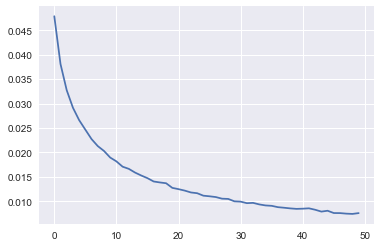

In [25]:
plt.plot(range(len(history.history['loss'])), history.history['loss'])
plt.show()

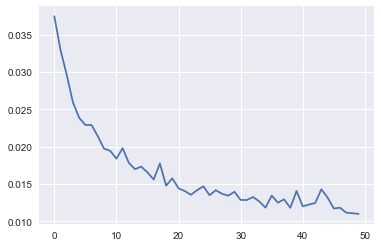

In [26]:
plt.plot(range(len(history.history['loss'])), history.history['val_loss'])
plt.show()

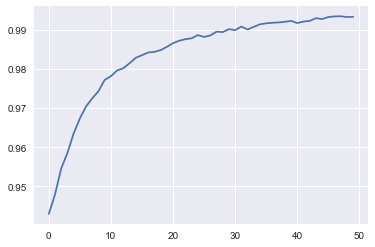

In [27]:
plt.plot(range(len(history.history['loss'])), history.history['accuracy'])
plt.show()

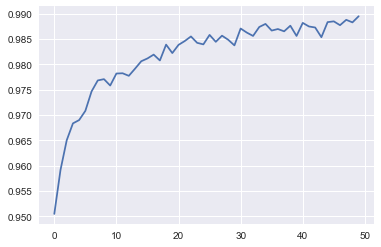

In [28]:
plt.plot(range(len(history.history['loss'])), history.history['val_accuracy'])
plt.show()

## Test

In [29]:
Y_topic

array(['Hallux valgus', 'HELLP-синдром', 'Абдоминальная мигрень', ...,
       'Ячмень на веке', 'Ячмень у ребенка', 'Ящур'], dtype='<U59')

In [30]:
test = np.zeros((1, 2, emb_size))

In [31]:
a = name2vector['Артроз голеностопного сустава']
b = name2vector['Артроз плечевого сустава']
test[0, 0, :] = a
test[0, 1, :] = b

In [32]:
model.predict([test[:, 0, :], test[:, 1, :]])

array([[0.10410519]], dtype=float32)

In [33]:
siamese_data.sample(5)

,name1,name2,target
13186,Кровотечение при беременности,Аллергический хейлит,0
6509,Брюшной тиф,Ксантоматоз,0
7703,Злоупотребление анаболическими стероидами,Алкогольная энцефалопатия,1
31155,Синдром Веста,Сепсис,0
29176,Нарколепсия,Заворот века,0


In [34]:
def getClosestDis(dis_name, model, Y_topic, emb_size, cnt):
    test = np.zeros((len(Y_topic), 2, emb_size))
    for ind, i in enumerate(Y_topic):
        test[ind, 0, :] = name2vector[dis_name]
        test[ind, 1, :] = name2vector[i]
        
    score = model.predict([test[:, 0, :], test[:, 1, :]]).ravel()
    indexs = np.argsort(np.array(score))
    
    res = [(Y_topic[i]) for i in indexs[1:cnt+1]]
    return res

In [35]:
name2topic['Артроз плечевого сустава'], name2topic['Переломы костей предплечья']

('Болезни ОДС и травмы', 'Болезни ОДС и травмы')

In [36]:
[(name2topic[i], i) for i in getClosestDis('Артроз плечевого сустава', model, Y_topic, emb_size, 10)]

[('Болезни ОДС и травмы', 'Хронический синовит'),
 ('Болезни ОДС и травмы', 'Острый периостит'),
 ('Болезни ОДС и травмы', 'Эпикондилит'),
 ('Болезни ОДС и травмы', 'Болезнь де Кервена'),
 ('Болезни ОДС и травмы', 'Рассекающий остеохондрит'),
 ('Болезни ОДС и травмы', 'Артроз голеностопного сустава'),
 ('Болезни ОДС и травмы', 'Артроз'),
 ('Болезни ОДС и травмы', 'Стенозирующий лигаментит'),
 ('Болезни ОДС и травмы', 'Деформации конечностей'),
 ('Болезни ОДС и травмы', 'Тендинит плечевого сустава')]

In [37]:
def cos_sim(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

In [38]:
def getSim(vec, cnt):
    sim = []
    for i in X_topic:
        sim.append(cos_sim(vec, i))
    indexs = np.argsort(np.array(sim))
    
    res = [(Y_topic[i]) for i in indexs[-cnt:]]
    return list(reversed(res))

In [39]:
[(name2topic[i], i) for i in getSim(name2vector['Артроз плечевого сустава'], 10)]

[('Болезни ОДС и травмы', 'Артроз плечевого сустава'),
 ('Болезни ОДС и травмы', 'Артроз'),
 ('Болезни ОДС и травмы', 'Артроз голеностопного сустава'),
 ('Болезни ОДС и травмы', 'Гонартроз'),
 ('Болезни ОДС и травмы', 'Коксартроз'),
 ('Болезни ОДС и травмы', 'Болезнь Пертеса'),
 ('Болезни ОДС и травмы', 'Посттравматический артроз'),
 ('Болезни ОДС и травмы', 'Поясничный спондилоартроз'),
 ('Болезни ОДС и травмы', 'Рассекающий остеохондрит'),
 ('Болезни ОДС и травмы', 'Тендинит коленного сустава')]

In [40]:
model.layers

In [41]:
intermediate_layer_model = Model(inputs=model.input,
                                    outputs=model.get_layer('lambda_1').output)

In [42]:
intermediate_output = intermediate_layer_model.predict([test[:, 0, :], test[:, 1, :]])
print(intermediate_output)

[[0.10410519]]


In [43]:
get_3rd_layer_output = K.function([input_a, input_b] + [K.learning_phase()], 
                                  [processed_a, processed_b])

In [47]:
tmp = [test[:, 0, :], test[:, 1, :]]

In [48]:
layer_outs = get_3rd_layer_output([tmp, 0])

ValueError: Cannot feed value of shape (2, 1, 250) for Tensor 'input_2:0', which has shape '(?, 250)'

In [45]:
model.layers[2].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 176)               44176     
_________________________________________________________________
dropout_1 (Dropout)          (None, 176)               0         
_________________________________________________________________
embedding_layer (Dense)      (None, 128)               22656     
Total params: 66,832
Trainable params: 66,832
Non-trainable params: 0
_________________________________________________________________


In [46]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 250)           0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 250)           0                                            
____________________________________________________________________________________________________
model_1 (Model)                  (None, 128)           66832       input_2[0][0]                    
                                                                   input_3[0][0]                    
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 1)             0           model_1[1][0]           